# Coulomb Stopping Power Tests

Module stoppingpower contains routines for numerical integration of stopping powers for incident charged particles Coulomb scattering off a $T=0$ Fermi sea of electrons.  No asumptions are made about the incident particle's mass or initial kinematics.   

In [37]:
%matplotlib inline

import time 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,20]

import stoppingpower as sp
reload(sp)

<module 'stoppingpower' from 'stoppingpower.py'>

### Carbon ion and pion tests

In [38]:
m_electron = 0.5 # MeV
Z_electron = -1.0 # charge
n_electron = 10**32 # cm^{-3}, electron number density

M_carbon = 10**4 # MeV
Z_carbon = 6.0
M_pion = 10**2 # Mev
Z_pion = 1.0
M_heavy = 10**7 # Mev
Z_heavy = 1.0

Initialize Fermi Sea properties, and construct stopping power functions.  This sets the energy unit to be MeV and the stopping power will be given in MeV/cm.

In [39]:
wd = sp.FermiSea_StoppingPower(m=m_electron, n0=n_electron, 
                               masstolength=sp.MeV_to_InvCM)
dedx_carbon_func = wd.get_ion_coulomb_stopping_power(M_carbon, Z_carbon)
dedx_pion_func = wd.get_ion_coulomb_stopping_power(M_pion, Z_pion)
dedx_heavy_func = wd.get_ion_coulomb_stopping_power(M_heavy, Z_heavy)

Stopping power functions accept an (array of) incident kinetic energy and do a monte carlo integral over electron momentum, direction, and com scattering angle.  

In [4]:
dedx_carbon_func(100.0, samples=1000)

array([[ 17949763.50197387],
       [ 16926780.40238205]])

In [5]:
timeit dedx_carbon_func([10.0**-2, 1.0, 100.0, 10**4, 10**6], samples=1000)

1 loop, best of 3: 257 ms per loop


Timing: 0.2 sec per 1000 samples. 
Need at least 10^5 samples for percent-level accuracy - thats at least 20 sec per calculation or about 3 hours to construct a 500 point plot. 

In [46]:
ke = np.logspace(1, 13, 100)  # 100 samples log-spaced between 10^-4 and 10^9
samples = 10**5
t0 = time.time()
dedx_carbon, dedx_carbon_error = dedx_carbon_func(ke, samples=samples, important=True)
dedx_pion, dedx_pion_error = dedx_pion_func(ke, samples=samples, important=True)
dedx_heavy, dedx_heavy_error = dedx_heavy_func(ke, samples=samples, important=True)
print "finished in {:0.2f} minutes".format((time.time() - t0)/60.0)

finished in 30.85 minutes


stoppingpower can also construct an approximate function based on the limiting cases of small or large incident momentum, both in the limit of a heavy incident and relativistic targets ('high density'). The function high_density_limiting is the quadrature sum of these two limits. 

The low energy limit is valid as long as incident momentum is non-relativisitc and greater than the target momentum (and maybe greater than the target mass as well...not sure).  This is Paul's esitmate, and gives $dE/dx \sim E^{1/2}$ ($E$ is incident kinetic energy). This involves an integral over scattering and incident angles which becomes an overall constant factor in the limit of incident momentum larger than the electron momentum. I haven't done this integral, but rather set the factor by eye.   

The high energy limit takes the electrons to be at rest and the incident to be highly relativistic, which gives a constant stopping power a la Jackson. I've used the exact Jackson result, with the Coulomb log set to $10$.  I suspect that for highly relativistic electrons this result is still valid for energetic enough incident particles, but the factor of electron mass ought to be replaced by the electron total energy ('relativistic inertia').  I have used the electron mass here, which ought to be fine as the electrons are only $\sim O(1)$ relativistic for WD densities.   

In [43]:
def momentum_threshold(p_electron, M_ion):
    """ The minimum incident momentum at which the low-energy PR estimate is valid """
    return (p_electron**2)/(2*M_ion)

def func_quadrature_sum(func1, func2):
    """ Takes two functions and returns a quadrature sum function """
    def quad_sum(x):
        return np.sqrt(func1(x)**2 + func2(x)**2)
    return quad_sum

In [44]:
dedx_carbon_approx_func =  wd.approx_sp_piecewise(M_carbon, Z_carbon)
dedx_pion_approx_func =  wd.approx_sp_piecewise(M_pion, Z_pion)
dedx_heavy_approx_func = wd.approx_sp_piecewise(M_heavy, Z_heavy)

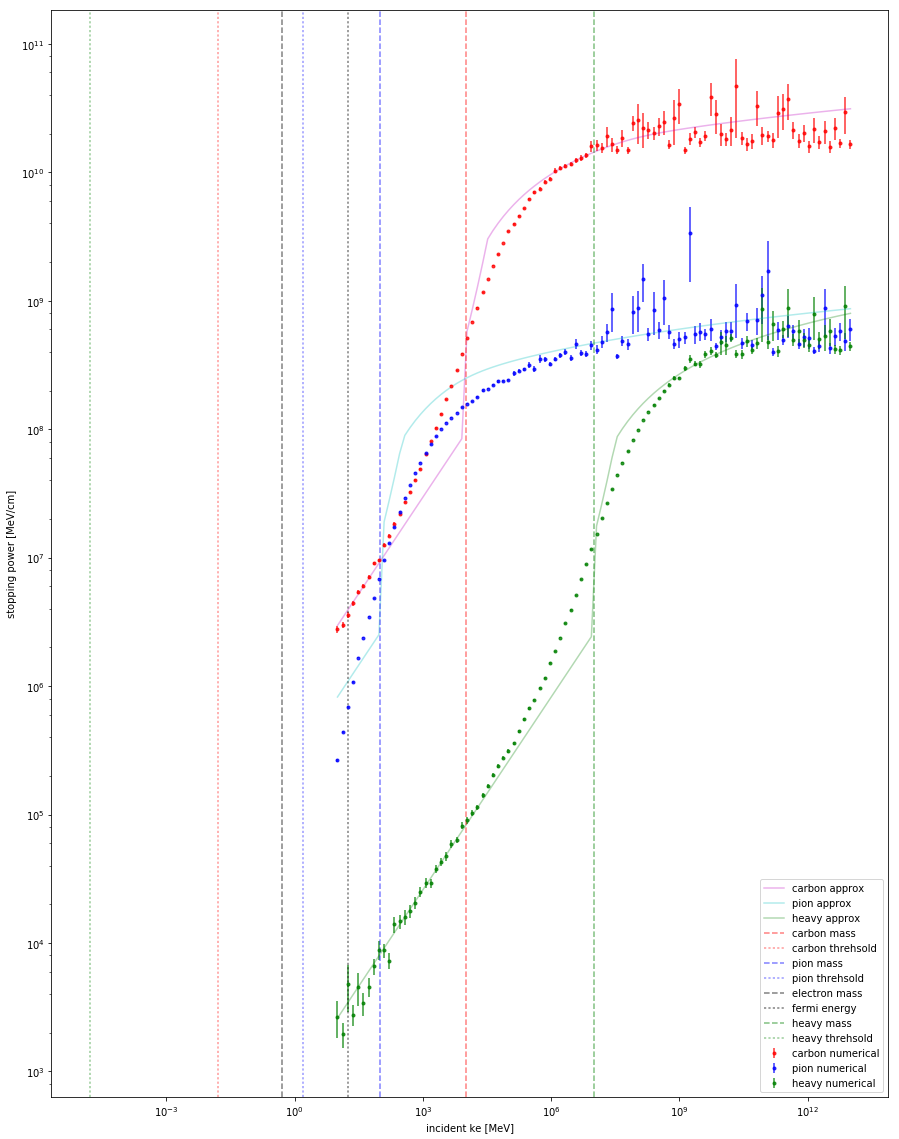

In [47]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_carbon, yerr=dedx_carbon_error, alpha=0.8,
            marker='.', linestyle='', color='r', label='carbon numerical')
ax.errorbar(ke, dedx_pion, yerr=dedx_pion_error, alpha=0.8,
            marker='.', linestyle='', color='b', label='pion numerical')
ax.errorbar(ke, dedx_heavy, yerr=dedx_heavy_error, alpha=0.8,
            marker='.', linestyle='', color='g', label='heavy numerical')

# limiting approximations
ax.plot(ke, dedx_carbon_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon approx')
ax.plot(ke, dedx_pion_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion approx')
ax.plot(ke, dedx_heavy_approx_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy approx')

# energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, label="carbon mass")
ax.axvline(momentum_threshold(wd.pfermi, M_carbon), linestyle=':', color='r', alpha=0.4, label="carbon threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, label="pion mass")
ax.axvline(momentum_threshold(wd.pfermi, M_pion), linestyle=':', color='b', alpha=0.4, label="pion threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, label="heavy mass")
ax.axvline(momentum_threshold(wd.pfermi, M_heavy), linestyle=':', color='g', alpha=0.4, label="heavy threhsold")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

In [ ]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, ke/dedx_carbon, yerr=ke*dedx_carbon_error/(dedx_carbon**2), alpha=0.8,
            marker='.', linestyle='', color='r', label='carbon numerical')
ax.errorbar(ke, ke/dedx_pion, yerr=ke*dedx_pion_error/(dedx_pion**2), alpha=0.8,
            marker='.', linestyle='', color='b', label='pion numerical')
# limiting approximations
ax.plot(ke, ke/dedx_carbon_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m')
ax.plot(ke, ke/dedx_carbon_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='m', 
        label='carbon limiting approx')
ax.plot(ke, ke/dedx_pion_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c')
ax.plot(ke, ke/dedx_pion_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='c', 
        label='pion limiting approx')
# significant energy scales 
ax.axvline(M_carbon, linestyle='--', color='r', alpha=0.5, label="carbon mass")
ax.axvline(momentum_threshold(wd.pfermi, M_carbon), linestyle=':', color='r', alpha=0.4, label="carbon threhsold")
ax.axvline(M_pion, linestyle='--', color='b', alpha=0.5, label="pion mass")
ax.axvline(momentum_threshold(wd.pfermi, M_pion), linestyle=':', color='b', alpha=0.4, label="pion threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("range [cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

### TeV incident particle tests

The low energy behavior does not quite match the expectation of $E^{1/2}$, but there are hints.  The pion curve is garbage.  But for the carbon, the curve appears to have slope $1$ just left of the flat portion, and then this slope seems to shallow a bit before it cuts off due to Pauli blocking.  

The $\sim E^{1/2}$ is due to finding $dE/dt \sim E$ and then dividing by the incident velocity $v \sim E^{1/2}$. For a relativistic incidnt, $v\sim 1$ should give a linear stopping power. So perhaps there are four regimes in this plot: Pauli cut off, non-relativistic stationary incident, relativistic stationary incident, and relativistic incident with stationary electrons. For different incident masses, these regions may overlap.  In the pion case it seems the cut off crushes any non-relativistic stationary behavior. 

A very heavy incident will push the Pauli cut off to lower energy, and the relativistic transition to larger energies - hopefully this will open up a clear $E^{1/2}$ region. 

In [ ]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, dedx_heavy, yerr=dedx_heavy_error, alpha=0.8,
            marker='.', linestyle='', color='g', label='heavy numerical')
# limiting approximations
ax.plot(ke, dedx_heavy_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g')
ax.plot(ke, dedx_heavy_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy limiting approx')
# significant energy scales 
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, label="heavy mass")
ax.axvline(momentum_threshold(wd.pfermi, M_heavy), linestyle=':', color='g', alpha=0.4, label="heavy threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("stopping power [MeV/cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

In [ ]:
fig, ax = plt.subplots()

# numerical results 
ax.errorbar(ke, ke/dedx_heavy, yerr=ke*dedx_heavy_error/(dedx_heavy**2), alpha=0.8,
            marker='.', linestyle='', color='g', label='heavy numerical')
# limiting approximations
ax.plot(ke, ke/dedx_heavy_jackson_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g')
ax.plot(ke, ke/dedx_heavy_riggins_func(ke), alpha=0.3,
        marker='', linestyle='-', color='g', 
        label='heavy limiting approx')
# significant energy scales 
ax.axvline(M_heavy, linestyle='--', color='g', alpha=0.5, label="heavy mass")
ax.axvline(momentum_threshold(wd.pfermi, M_heavy), linestyle=':', color='g', alpha=0.4, label="heavy threhsold")
ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")

ax.set_xlabel("incident ke [MeV]")
ax.set_ylabel("range [cm]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

Here we have the $1/2$ scaling as expected. 

### Comparisons with PR's result

Paul independently made the same calculation as above, with drastically different results.  We've narrowed the difference down to a comparison of the factors 
$$
\frac{p^{ion}_{com} \; E^{total}_{com}}{p^{ion}_{lab} \; E^{electron}_{lab}}
   \stackrel{?}{=} \frac{|v_{rel, lab}|}{\gamma_{v_{com, perp}}}
$$
with the lefthand side being my result and the right Pauls.  The lefthand factors are extracted and plotted below. 

In [ ]:
import kinematics_2plus1 as kn
import numpy.linalg as la

def boost_factors(electron_energy, pion_energy, theta_incident):
    """ """
    p4_e = kn.polarkinetic_to_4vec(electron_energy, theta_incident, 0.5)
    p4_p = kn.polarkinetic_to_4vec(pion_energy, 0.0, 100.0)
    vcom = kn.get_com_velocity(p4_e, p4_p)
    boost, revboost = kn.boost_and_inverse_matricies(vcom)
    p4_e_com = boost.dot(p4_e)
    p4_p_com = boost.dot(p4_p)
    E_tot_com = p4_e_com[0] + p4_p_com[0]
    return (la.norm(p4_p_com[1:3])*E_tot_com)/(p4_e[0]*la.norm(p4_p[1:4]))
    

In [ ]:
fig, ax = plt.subplots()

ke = np.logspace(-4, 9, 1000)
bf = np.ones(ke.shape)*np.nan
for index, ke_i in enumerate(ke):
    bf[index] = boost_factors(10.0, ke_i, 0.1)
    
ax.plot(ke, bf, linestyle='-', marker='')
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
print ke[0], bf[0]
print ke[-1], bf[-1]

### Incident electrons

Note that this is ignoring identical particle effects. 

In [ ]:
dedx_electron_func = wd.get_ion_coulomb_stopping_power(wd.m, wd.z)
dedx_heavy_riggins_func = wd.high_density_slow_ion(wd.m, wd.z)
dedx_heavy_jackson_func = wd.high_density_fast_ion(wd.m, wd.z)
ke = np.logspace(-4, 9, 100)  # 100 samples log-spaced between 10^-4 and 10^9

In [ ]:
dedx_electron, dedx_electron_error = dedx_electron_func(ke, samples=10**4, important=True)

In [ ]:
fig, axes = plt.subplots(2, 1)
ax_sp, ax_lambda = axes

# numerical results 
ax_sp.errorbar(ke, dedx_electron, yerr=dedx_electron_error, alpha=0.8,
               marker='.', linestyle='', color='g', label='numerical')
ax_lambda.errorbar(ke, ke/dedx_electron, yerr=ke*dedx_electron_error/(dedx_electron**2),
                   alpha=0.8, marker='.', linestyle='', color='g')
# limiting approximations
ax_sp.plot(ke, dedx_heavy_jackson_func(ke), alpha=0.3,
           marker='', linestyle='-', color='g')
ax_sp.plot(ke, dedx_heavy_riggins_func(ke), alpha=0.3,
           marker='', linestyle='-', color='g', 
           label='limiting approximatons')
ax_lambda.plot(ke, ke/dedx_heavy_jackson_func(ke), alpha=0.3,
               marker='', linestyle='-', color='g')
ax_lambda.plot(ke, ke/dedx_heavy_riggins_func(ke), alpha=0.3,
               marker='', linestyle='-', color='g')
# significant energy scales 
for ax in axes:
    ax.axvline(momentum_threshold(wd.pfermi, wd.m), linestyle=':', 
               color='g', alpha=0.4, label="heavy threhsold")
    ax.axvline(wd.m, linestyle='--', color='k', alpha=0.5, label="electron mass")
    ax.axvline(wd.Efermi, linestyle=':', color='k', alpha=0.5, label="fermi energy")
    # cosmetics 
    ax.set_xlabel("incident ke [MeV]")
    ax.set_xscale("log")
    ax.set_yscale("log")
ax_sp.set_ylabel("stopping power [MeV/cm]")
ax_sp.set_title("Incident Electron Stopping Power")
ax_lambda.set_ylabel("range [cm]")
ax_lambda.set_title("Incident Electron Range")
ax_lambda.legend(loc="best")